# Test the new classes for storing and querying GP samples.

## Setup

In [1]:
import os
import sys

os.chdir("..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src import load, munge
import src.models.gp

In [3]:
import importlib
importlib.reload(src.load)
importlib.reload(src.munge)
importlib.reload(src.models.gp)

<module 'src.models.gp' from '/Users/yl3/github/dota2/src/models/gp.py'>

## Load data.

### Load matches.

In [4]:
matches = load.all_matches_df()

In [404]:
matches_ti9 = matches.loc[matches.league_name == "The International 2019"]
matches_ti9.shape

(268, 15)

In [6]:
players_mat_ti9 = munge.make_match_players_matrix(
    matches_ti9.radiant_players, matches_ti9.dire_players)
players_mat_ti9.shape

(268, 240)

### Load players.

In [7]:
players = munge.player_id_to_player_name(
    pd.concat([matches_ti9.radiant_players, matches_ti9.dire_players]),
    pd.concat([matches_ti9.radiant_nicknames, matches_ti9.dire_nicknames]),
    pd.concat([matches_ti9.radiant_valveId, matches_ti9.dire_valveId]),
    pd.concat([matches_ti9.radiant_name, matches_ti9.dire_name]),)

In [8]:
players.loc[players_mat_ti9.columns[:5]]

,name,team,team_id
3916428,EGM,Bald,7237270
3940262,March,Team Jinesbrus,7225724
4281729,syndereN,Anti-MagE-,7247587
6922000,pieliedie,Forward Gaming,6214538
10366616,Sneyking,Forward Gaming,6214538


## Make sure the model still runs as before, with initialisation at 0.

In [313]:
two_years_in_ms = 2 * 365 * 24 * 60 * 60 * 1000

In [314]:
import importlib
importlib.reload(src.load)
importlib.reload(src.munge)
importlib.reload(src.models.gp)

<module 'src.models.gp' from '/Users/yl3/github/dota2/src/models/gp.py'>

In [109]:
gp = src.models.gp.SkillsGP(
    players_mat_ti9,
    matches_ti9.startTimestamp.values,
    matches_ti9.radiantVictory,
    players_mat_ti9.columns.values,
    "exponential",
    {"scale": two_years_in_ms},
    propose_sd=0.1,
    radi_prior_sd=100,  # Non-informative prior
    logistic_scale=1,
    save_every_n_iter=10
)

In [110]:
gp.iterate_once_player_wise()

In [111]:
print(gp.samples.samples[0])

[0] log_posterior: 7206.02434633458, radi_adv: 0.0, skills: [0. 0. 0. ... 0. 0. 0.]


In [112]:
gp._cur_iter

0

### See if we can run through 100 iterations.

In [113]:
gp.iterate(100, "playerwise")

100% (100 of 100) |######################| Elapsed Time: 0:00:04 Time:  0:00:04


Text(0.5, 1.0, 'Radiant advantage')

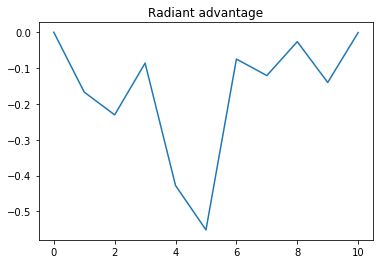

In [114]:
plt.plot([x.radi_adv for x in gp.samples.samples])
plt.title("Radiant advantage")

Text(0.5, 1.0, 'log-posterior')

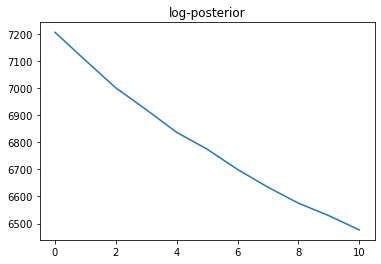

In [117]:
plt.plot([x.log_posterior for x in gp.samples.samples])
plt.title("log-posterior")

In [118]:
print(gp.samples)

[0] log_posterior: 7206.02434633458, radi_adv: 0.0, skills: [0. 0. 0. ... 0. 0. 0.]
[10] log_posterior: 7102.530570853061, radi_adv: -0.16699848226733088, skills: [0.05946592 0.06051579 0.06177947 ... 0.37228899 0.37074165 0.36578583]
[20] log_posterior: 7000.678308635222, radi_adv: -0.23050617874148532, skills: [0.22956212 0.22796654 0.23138676 ... 0.50234214 0.50307845 0.50092461]
[30] log_posterior: 6920.419358620412, radi_adv: -0.08613307007970346, skills: [-0.05856412 -0.06249396 -0.0593072  ...  0.44791452  0.4386288
  0.43256007]
[40] log_posterior: 6836.6869586741595, radi_adv: -0.42745546239985716, skills: [0.30972307 0.30048206 0.30049713 ... 0.55761631 0.54684398 0.54102953]
[50] log_posterior: 6774.639420723391, radi_adv: -0.5513794403436998, skills: [0.50547219 0.50403947 0.50996961 ... 0.57305297 0.56294919 0.55677774]
[60] log_posterior: 6699.795965988585, radi_adv: -0.07477429603310251, skills: [0.79303499 0.79390211 0.80061557 ... 0.63989696 0.62848825 0.62616706]
[70]

## Check if we can run the model starting from a provided initial sample.

In [315]:
initial_sample = gp.samples.samples.iloc[-1]
str(initial_sample)

'[1100] log_posterior: 5924.979714356932, radi_adv: 0.3561516680667399, skills: [0.30729024 0.29152052 0.29122442 ... 2.11897851 2.11840147 2.12335745]'

In [317]:
importlib.reload(src.models.gp)

<module 'src.models.gp' from '/Users/yl3/github/dota2/src/models/gp.py'>

In [318]:
gp2 = src.models.gp.SkillsGP(
    players_mat_ti9,
    matches_ti9.startTimestamp.values,
    matches_ti9.radiantVictory,
    players.loc[players_mat_ti9.columns].name,
    "exponential",
    {"scale": two_years_in_ms},
    propose_sd=0.1,
    radi_prior_sd=100,  # Non-informative prior
    radi_offset_proposal_sd=0.01,
    logistic_scale=1,
    save_every_n_iter=10,
    initial_sample=initial_sample
)

In [319]:
display(gp2._cur_iter)
display(gp2._cur_log_posterior)
display(gp2._cur_radi_adv)
str(gp2.samples.samples.iloc[-1])

1100

5924.9797143569324227

0.3561516680667399

'[1100] log_posterior: 5924.979714356932, radi_adv: 0.3561516680667399, skills: [0.30729024 0.29152052 0.29122442 ... 2.11897851 2.11840147 2.12335745]'

In [320]:
gp2.player_skill_vecs[0][0].state

array([ 0.30729024, -1.06089067, -0.02110993,  1.00807949, -0.25809488,
        0.89687408,  0.18692814], dtype=float128)

### See if we can run through 100 iterations.

In [321]:
gp2.iterate(100, "playerwise")

100% (100 of 100) |######################| Elapsed Time: 0:00:05 Time:  0:00:05


Text(0.5, 1.0, 'Radiant advantage')

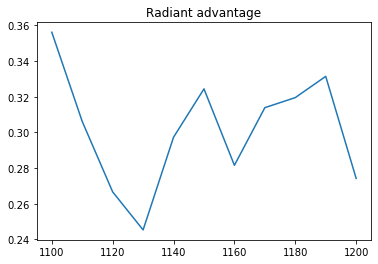

In [322]:
plt.plot([x.iter for x in gp2.samples.samples],
         [x.radi_adv for x in gp2.samples.samples])
plt.title("Radiant advantage")

Text(0.5, 1.0, 'log-posterior')

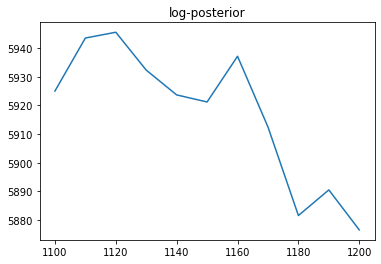

In [323]:
plt.plot([x.iter for x in gp2.samples.samples],
         [x.log_posterior for x in gp2.samples.samples])
plt.title("log-posterior")

### Test slicing.

In [324]:
print(gp2.samples[-1:])

[1200] log_posterior: 5876.6067226077, radi_adv: 0.27419363085433635, skills: [0.32203782 0.30393121 0.30320853 ... 1.99655155 1.98786091 1.99151559]


## Run 2,000 iterations, then test if sample querying works.

In [325]:
gp2.iterate(2000, "playerwise")

100% (2000 of 2000) |####################| Elapsed Time: 0:01:18 Time:  0:01:18


In [326]:
print(gp2.samples[-3:])

[3180] log_posterior: 5967.106245314362, radi_adv: -0.056108680714838474, skills: [ 0.67750749  0.67610232  0.67283618 ... -2.37523714 -2.3723213
 -2.38559903]
[3190] log_posterior: 5962.19682554533, radi_adv: -0.053236450742486424, skills: [ 0.89181722  0.88528152  0.88648152 ... -2.19015255 -2.18055769
 -2.19345636]
[3200] log_posterior: 5950.1185566591685, radi_adv: -0.08052177354382296, skills: [ 0.68244184  0.67783363  0.6769108  ... -2.08296309 -2.06930181
 -2.0804425 ]


Text(0.5, 1.0, 'Radiant advantage')

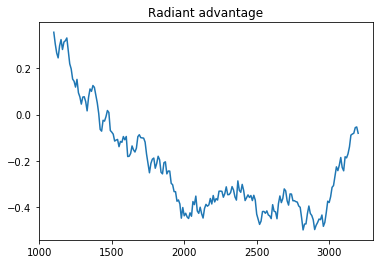

In [327]:
plt.plot([x.iter for x in gp2.samples.samples],
         [x.radi_adv for x in gp2.samples.samples])
plt.title("Radiant advantage")

In [426]:
src.models.gp.win_prob(-0.22822594222496298, gp2.logistic_scale)

0.4431898900387288

Text(0.5, 1.0, 'log-posterior')

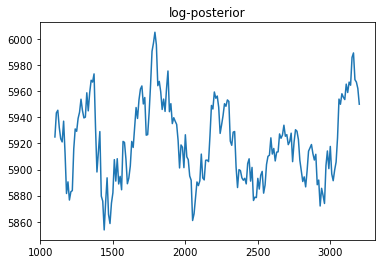

In [328]:
plt.plot([x.iter for x in gp2.samples.samples],
         [x.log_posterior for x in gp2.samples.samples])
plt.title("log-posterior")

### Save (and reload) samples.

In [422]:
importlib.reload(src.models.gp)

<module 'src.models.gp' from '/Users/yl3/github/dota2/src/models/gp.py'>

In [423]:
sample_set = src.models.gp.GPSampleSet.from_sample_set(gp2.samples)

### `GPSampleSet.player_skill_by_sample()`

In [331]:
print(sample_set.players.to_string())

3916428                   EGM
3940262                 March
4281729              syndereN
6922000             pieliedie
10366616             Sneyking
11550182              VANSKOR
12231202                Limmp
18180970             Handsken
20321748           SexyBamboe
26316691              Illidan
28070572               papita
29904110                    B
31818853                 Brax
37658157                  c4t
38628747          MoonMeander
40209325          jonassomfan
40805086             mellojul
43619695      HeStEJoE-RoTTeN
50580004                Xibbe
50828662               Zfreek
52406002                steph
56939869                Gorgc
58513047              Stussy^
59463394             Leostyle
59752811                   no
67428263              Unknown
68007361                  Muf
71869498                 Luft
72312627           MATUMBAMAN
81852496             Afoninje
82305765              velheor
83867257           Pingvincek
84429681                  Moo
84853828  

In [332]:
player_skill_by_sample = sample_set.player_skill_by_sample("pieliedie")

In [333]:
player_skill_by_sample

matchId,4904311356,4904261164,4904218149,4904171017,4901998619,4901925673,4901799568,4901733286,4899990684,4899794936,4898286553,4898190830,4898118360,4898062038,4897799006
iter,,,,,,,,,,,,,,,
1100,0.417088,0.421372,0.438641,0.445161,0.462900,0.463545,0.471998,0.468238,0.510956,0.520159,0.492378,0.492615,0.477832,0.471750,0.465384
1110,0.666748,0.671705,0.688458,0.696123,0.728835,0.732631,0.738646,0.737059,0.785367,0.797724,0.768606,0.772639,0.755076,0.744195,0.728935
1120,0.413704,0.418711,0.436699,0.442909,0.486465,0.491601,0.490855,0.493636,0.537178,0.559734,0.517664,0.524189,0.503747,0.491639,0.483848
1130,0.173725,0.181440,0.194845,0.196157,0.228059,0.237967,0.234875,0.238924,0.285268,0.295553,0.264578,0.269344,0.247416,0.226759,0.218268
1140,0.309825,0.323598,0.335852,0.338696,0.378735,0.387271,0.391150,0.396100,0.406985,0.422744,0.397406,0.400616,0.389324,0.370886,0.364291
1150,0.476749,0.491935,0.503385,0.506821,0.552134,0.558605,0.565114,0.567488,0.548711,0.573357,0.550609,0.554677,0.552646,0.536725,0.532562
1160,0.149193,0.165294,0.179904,0.177608,0.223827,0.230773,0.235753,0.231276,0.197438,0.216142,0.178236,0.184574,0.183463,0.168799,0.170906
1170,0.192040,0.211164,0.224532,0.220342,0.265922,0.279556,0.289955,0.285796,0.263640,0.284096,0.262840,0.271472,0.271631,0.259201,0.267216
1180,0.318035,0.338805,0.358669,0.353048,0.408251,0.418398,0.430723,0.428143,0.417238,0.432840,0.413865,0.425552,0.418573,0.410362,0.409671


In [334]:
player_skill_by_sample.shape

(211, 15)

### Average skill of player across matches and samples.

In [378]:
skills_by_player = pd.Series(
    [np.mean(sample_set.player_skill_by_sample(player).values)
     for player in sample_set.players.index],
    index=sample_set.players.index,
    name="skill")
print(skills_by_player.sort_values(ascending=False).to_string())

412753955    1.214730
106809101    1.128712
108452107    1.051880
119631156    1.050169
10366616     1.048704
18180970     1.007982
81852496     0.994165
186837494    0.976794
342340720    0.974230
349310876    0.960142
171981096    0.877303
112377459    0.859702
182993582    0.844489
107081378    0.806861
58513047     0.766292
115141430    0.727176
169025618    0.725653
175463659    0.684282
104512126    0.681565
168028715    0.651663
169359249    0.643645
116876282    0.637105
133558180    0.633699
86726887     0.619473
114619230    0.580051
142139318    0.571472
139822354    0.571002
190710801    0.565595
115102590    0.555002
71869498     0.532147
480412663    0.531936
83867257     0.524061
129645604    0.520424
237325411    0.493593
186627166    0.493091
127077041    0.491991
86785083     0.478412
88585077     0.474927
85937380     0.431024
292921272    0.430068
38628747     0.423271
145065875    0.417196
249651648    0.415023
138857296    0.407297
3940262      0.402397
59463394  

In [389]:
team_skills = (players.assign(skill=skills_by_player)
               .sort_values("skill")
               .groupby("team").agg({"skill": "sum"})
               .sort_values("skill", ascending=False))
team_skills

,skill
team,
Forward Gaming,2.914148
Chaos Esports Club,2.227049
Vega Squadron,1.906558
Infamous Gaming,1.811783
Natus Vincere,1.723160
Mineski,1.584642
The Final Tribe,1.547902
Team Jinesbrus,1.413622
Hippomaniacs,1.375154


In [387]:
from scipy.spatial.distance import pdist, squareform

In [394]:
pd.DataFrame(
    squareform(pdist(team_skills, metric=lambda x, y: 1 / (1 + np.exp((y - x))))),
    index=team_skills.index,
    columns=team_skills.index).iloc[:10, :10]

team,Forward Gaming,Chaos Esports Club,Vega Squadron,Infamous Gaming,Natus Vincere,Mineski,The Final Tribe,Team Jinesbrus,Hippomaniacs,J.Storm
team,,,,,,,,,,
Forward Gaming,0.000000,0.665321,0.732548,0.750703,0.766918,0.790759,0.796773,0.817653,0.823318,0.835723
Chaos Esports Club,0.665321,0.000000,0.579444,0.602350,0.623373,0.655297,0.663548,0.692839,0.700965,0.719028
Vega Squadron,0.732548,0.579444,0.000000,0.523676,0.545721,0.579791,0.588715,0.620798,0.629810,0.650026
Infamous Gaming,0.750703,0.602350,0.523676,0.000000,0.522141,0.556542,0.565590,0.598246,0.607455,0.628172
Natus Vincere,0.766918,0.623373,0.545721,0.522141,0.000000,0.534574,0.543703,0.576773,0.586134,0.607248
Mineski,0.790759,0.655297,0.579791,0.556542,0.534574,0.000000,0.509184,0.542651,0.552181,0.573768
The Final Tribe,0.796773,0.663548,0.588715,0.565590,0.543703,0.509184,0.000000,0.533520,0.543080,0.564759
Team Jinesbrus,0.817653,0.692839,0.620798,0.598246,0.576773,0.542651,0.533520,0.000000,0.509616,0.531513
Hippomaniacs,0.823318,0.700965,0.629810,0.607455,0.586134,0.552181,0.543080,0.509616,0.000000,0.521924


### `GPSampleSet.team_skill_by_sample()`

In [449]:
radi_skill_by_sample = sample_set.team_skill_by_sample()
radi_skill_by_sample

matchId,4904311356,4904261164,4904218149,4904171017,4904062522,4903974414,4903679968,4903566049,4903441151,4903243468,...,4889163811,4889115579,4889038294,4888974952,4888936676,4888859291,4888772755,4888732113,4888686136,4888646940
iter,,,,,,,,,,,,,,,,,,,,,
1100,0.263707,2.136557,0.283140,2.139967,-0.529126,-0.535048,3.078231,2.036145,3.057034,3.029066,...,1.146608,-2.112800,0.994362,-2.067412,1.142213,0.426576,-1.917695,0.454146,0.836478,-2.093309
1110,0.778269,2.998913,0.780576,3.007461,-0.683960,-0.681841,3.476901,2.351587,3.465325,3.423667,...,1.341556,-1.522310,0.682123,-1.465958,1.348548,0.088485,-2.530820,0.123502,0.927577,-1.497244
1120,1.694462,3.276866,1.699121,3.274739,0.556343,0.559872,3.678091,2.506483,3.672530,3.634845,...,0.982364,-1.760493,1.364228,-1.698648,0.998301,0.098054,-2.801888,0.122234,0.178524,-1.716541
1130,1.542776,2.539913,1.541082,2.528494,-0.298146,-0.303550,3.385712,2.535005,3.386136,3.346048,...,1.064561,-1.946349,0.799683,-1.898901,1.074934,0.480871,-2.704490,0.510074,-0.545354,-1.905426
1140,1.300368,2.959453,1.293237,2.954177,0.117006,0.098882,3.610712,2.662906,3.623690,3.593966,...,0.999178,-0.821461,1.136804,-0.781324,1.014685,-0.531101,-2.895240,-0.514643,-0.330055,-0.776501
1150,0.911601,3.638623,0.905685,3.651211,-0.534049,-0.552943,3.031597,3.266899,3.058954,3.034698,...,1.049190,-0.054243,0.605747,-0.016688,1.061867,0.049770,-2.302592,0.074611,-0.885952,-0.003302
1160,1.063763,3.221302,1.077318,3.224996,0.298677,0.282291,3.312707,3.807416,3.346485,3.319429,...,0.450339,0.300109,0.706113,0.341926,0.453304,-0.537197,-2.704183,-0.510919,-0.385155,0.362703
1170,1.821251,2.634546,1.828894,2.633534,-0.614076,-0.627806,2.866753,3.458943,2.898929,2.885253,...,0.411598,-0.240273,0.787624,-0.191003,0.424141,-0.306831,-2.328316,-0.291850,1.542474,-0.183881
1180,1.967237,2.660407,1.992241,2.658594,0.462714,0.448128,3.549885,2.880788,3.570593,3.552385,...,0.815585,-0.451996,0.614846,-0.398890,0.830324,0.042127,-2.517024,0.059480,1.284254,-0.395352


In [450]:
dire_skill_by_sample = sample_set.team_skill_by_sample("dire")
dire_skill_by_sample

matchId,4904311356,4904261164,4904218149,4904171017,4904062522,4903974414,4903679968,4903566049,4903441151,4903243468,...,4889163811,4889115579,4889038294,4888974952,4888936676,4888859291,4888772755,4888732113,4888686136,4888646940
iter,,,,,,,,,,,,,,,,,,,,,
1100,2.098458,0.262383,2.105060,0.265437,0.219138,0.210257,2.049893,3.050592,2.055958,2.529970,...,0.778817,-0.148984,0.376070,-1.836717,-0.160542,0.805763,-0.108456,0.387172,1.022481,1.186011
1110,2.957240,0.761361,2.970234,0.769258,0.719805,0.711741,2.361000,3.455990,2.376163,3.389798,...,0.869459,0.346022,-0.235494,-2.459494,0.349696,0.888173,0.398270,-0.225548,0.711903,1.386563
1120,3.245033,1.690965,3.245739,1.700225,1.642425,1.637721,2.510272,3.658808,2.527739,2.660189,...,0.118966,0.437537,0.070813,-2.737932,0.434665,0.147919,0.480137,0.085004,1.400645,1.047962
1130,2.510987,1.541518,2.501276,1.539233,1.469640,1.453580,2.538112,3.373595,2.551641,2.975255,...,-0.574631,-0.040823,-0.301537,-2.631988,-0.049747,-0.567158,-0.005876,-0.299483,0.842740,1.124527
1140,2.917782,1.306314,2.919643,1.272568,1.196565,1.196663,2.671772,3.600875,2.681601,3.099063,...,-0.317696,-0.642483,-0.342231,-2.814546,-0.652160,-0.338388,-0.599694,-0.350404,1.189561,1.070723
1150,3.603453,0.917888,3.602997,0.884985,0.797791,0.789639,3.275571,3.024716,3.281361,3.042356,...,-0.874977,1.042267,-1.591208,-2.214045,1.034033,-0.897543,1.091986,-1.605025,0.635314,1.117961
1160,3.184312,1.080888,3.184959,1.058838,0.967256,0.949277,3.822859,3.307653,3.820477,2.801664,...,-0.372321,0.462534,-0.878950,-2.626607,0.452027,-0.394782,0.501963,-0.893347,0.725345,0.502350
1170,2.594172,1.831965,2.595525,1.807411,1.715567,1.699448,3.466056,2.863886,3.477563,1.660370,...,1.541935,1.128628,-1.637394,-2.267797,1.120136,1.521109,1.182379,-1.660635,0.788900,0.501435
1180,2.615345,1.987426,2.632371,1.966075,1.877627,1.856593,2.890657,3.543647,2.898277,1.152188,...,1.284869,0.189885,-0.860971,-2.430299,0.185193,1.276640,0.257967,-0.884543,0.624793,0.918352


In [451]:
skill_diff_mat = (-radi_skill_by_sample + dire_skill_by_sample).sub(
    sample_set.radi_adv_by_sample(), 'rows')
radi_win_prob_by_sample = 1 / (1 + np.exp(skill_diff_mat))
display(radi_win_prob_by_sample.shape)
radi_win_prob_by_sample.mean()

(211, 268)

matchId
4904311356    0.172201
4904261164    0.762482
4904218149    0.167757
4904171017    0.766970
4904062522    0.384107
4903974414    0.382757
4903679968    0.602441
4903566049    0.304113
4903441151    0.605972
4903243468    0.647529
4903157391    0.488561
4903091581    0.266880
4903051772    0.486022
4902924459    0.483445
4902837041    0.485587
4902729928    0.485178
4902576905    0.620937
4902464697    0.281939
4902354217    0.622489
4902186317    0.245175
4902122478    0.677918
4902056634    0.243533
4901998619    0.133518
4901925673    0.131767
4901835876    0.381434
4901799568    0.899092
4901742097    0.378436
4901733286    0.071142
4901728834    0.798417
4901646019    0.145454
                ...   
4890122311    0.283928
4889995626    0.078637
4889981518    0.848418
4889881001    0.514855
4889865830    0.707629
4889722230    0.288595
4889691529    0.382913
4889635707    0.440000
4889610539    0.301460
4889555136    0.609913
4889525518    0.183902
4889502467    0.586374
488

In [452]:
matches_ti9.assign(win_prob=radi_win_prob_by_sample.mean()).loc[
    :, ["radiant_name", "dire_name", "win_prob", "radiantVictory"]]

,radiant_name,dire_name,win_prob,radiantVictory
matchId,,,,
4904311356,J.Storm,Forward Gaming,0.172201,False
4904261164,Forward Gaming,J.Storm,0.762482,True
4904218149,J.Storm,Forward Gaming,0.167757,False
4904171017,Forward Gaming,J.Storm,0.766970,False
4904062522,beastcoast,J.Storm,0.384107,False
4903974414,beastcoast,J.Storm,0.382757,False
4903679968,Chaos Esports Club,The Final Tribe,0.602441,True
4903566049,The Final Tribe,Chaos Esports Club,0.304113,False
4903441151,Chaos Esports Club,The Final Tribe,0.605972,True


### `GPSampleSet.radi_adv_by_sample()`

In [446]:
sample_set.radi_adv_by_sample().mean()

-0.22822594222496298

### Win probability computed using `GPSampleSet.radi_win_prob_by_sample()`

In [447]:
win_prob_mat = sample_set.radi_win_prob_by_sample()
display(win_prob_mat.shape)
win_prob_mat

(211, 268)

matchId,4904311356,4904261164,4904218149,4904171017,4904062522,4903974414,4903679968,4903566049,4903441151,4903243468,...,4889163811,4889115579,4889038294,4888974952,4888936676,4888859291,4888772755,4888732113,4888686136,4888646940
iter,,,,,,,,,,,,,,,,,,,,,
1100,0.185639,0.902940,0.187587,0.902971,0.403209,0.403921,0.799711,0.341123,0.795309,0.701667,...,0.673475,0.166913,0.726004,0.531323,0.840091,0.494241,0.189527,0.604231,0.542435,0.051020
1110,0.133212,0.927147,0.131983,0.927191,0.250182,0.252097,0.805655,0.310393,0.801434,0.584188,...,0.685296,0.173330,0.772721,0.785777,0.786671,0.379054,0.067675,0.658175,0.627567,0.070588
1120,0.216881,0.864424,0.217553,0.863084,0.305880,0.307631,0.807594,0.291999,0.803990,0.775788,...,0.755845,0.126596,0.826360,0.786829,0.696412,0.553980,0.046735,0.575386,0.277782,0.076008
1130,0.326753,0.776207,0.328519,0.774616,0.179096,0.180668,0.748928,0.355881,0.746456,0.649330,...,0.868127,0.159732,0.793560,0.726789,0.797377,0.784711,0.079197,0.741707,0.241808,0.058159
1140,0.210796,0.875492,0.209304,0.878563,0.313829,0.309918,0.774905,0.345091,0.775454,0.688300,...,0.833987,0.529541,0.855241,0.911372,0.876979,0.526118,0.119385,0.533211,0.227526,0.175094
1150,0.085688,0.954572,0.085261,0.956504,0.267480,0.265380,0.520094,0.637972,0.525474,0.578528,...,0.904526,0.316021,0.925625,0.925653,0.587157,0.781034,0.044354,0.881219,0.232032,0.310695
1160,0.137169,0.918486,0.138703,0.920393,0.404430,0.404814,0.443094,0.685961,0.452035,0.689826,...,0.751046,0.529743,0.866065,0.962676,0.570236,0.534725,0.050951,0.660151,0.303865,0.535414
1170,0.387207,0.753327,0.388701,0.757676,0.117555,0.117803,0.429119,0.712778,0.434189,0.823281,...,0.306511,0.258257,0.939282,0.916111,0.405611,0.180334,0.039285,0.843254,0.744108,0.408188
1180,0.418580,0.729578,0.420523,0.733416,0.250601,0.251814,0.726856,0.414995,0.729447,0.938179,...,0.462624,0.420096,0.857578,0.913007,0.724049,0.285976,0.079038,0.779632,0.726903,0.270083


In [448]:
matches_ti9.assign(win_prob=win_prob_mat.mean()).loc[
    :, ["radiant_name", "dire_name", "win_prob", "radiantVictory"]]

,radiant_name,dire_name,win_prob,radiantVictory
matchId,,,,
4904311356,J.Storm,Forward Gaming,0.172201,False
4904261164,Forward Gaming,J.Storm,0.762482,True
4904218149,J.Storm,Forward Gaming,0.167757,False
4904171017,Forward Gaming,J.Storm,0.766970,False
4904062522,beastcoast,J.Storm,0.384107,False
4903974414,beastcoast,J.Storm,0.382757,False
4903679968,Chaos Esports Club,The Final Tribe,0.602441,True
4903566049,The Final Tribe,Chaos Esports Club,0.304113,False
4903441151,Chaos Esports Club,The Final Tribe,0.605972,True


## What is the autocorrelation between match win probabilities?

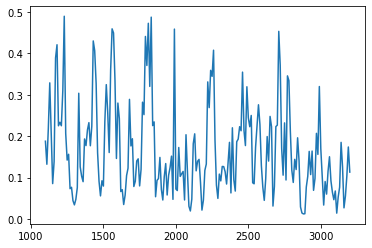

In [539]:
plt.plot(win_prob_mat.iloc[:, 2])

In [516]:
win_prob_autocorr = win_prob_mat.apply(
    lambda x: [x.autocorr(k) for k in range(20)], result_type='expand')

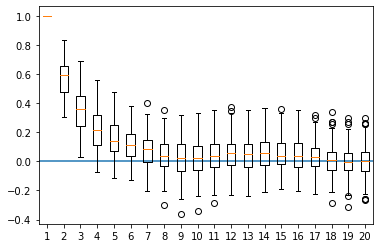

In [527]:
_ = plt.boxplot(win_prob_autocorr)
plt.axhline(0, zorder=0)

Seems like at a lag of 8 dozens of iterations (i.e. 80 individual interations), there is no autocorrelation left.

## What is the Radiant win probability estimate between the most recent sets of samples?

In [455]:
first_match_win_probs = win_prob_mat.iloc[-200:-100].mean()
first_match_win_probs

matchId
4904311356    0.177946
4904261164    0.778724
4904218149    0.173007
4904171017    0.785697
4904062522    0.372651
4903974414    0.371932
4903679968    0.582420
4903566049    0.344112
4903441151    0.591455
4903243468    0.653394
4903157391    0.500188
4903091581    0.287498
4903051772    0.499962
4902924459    0.501110
4902837041    0.502888
4902729928    0.500625
4902576905    0.621618
4902464697    0.304376
4902354217    0.623569
4902186317    0.267287
4902122478    0.672926
4902056634    0.266270
4901998619    0.126468
4901925673    0.125977
4901835876    0.389301
4901799568    0.913895
4901742097    0.380686
4901733286    0.069306
4901728834    0.786523
4901646019    0.167496
                ...   
4890122311    0.269141
4889995626    0.096240
4889981518    0.812945
4889881001    0.490053
4889865830    0.720168
4889722230    0.274477
4889691529    0.375490
4889635707    0.501996
4889610539    0.294808
4889555136    0.623251
4889525518    0.186625
4889502467    0.662653
488

In [456]:
second_match_win_probs = win_prob_mat.iloc[-100:].mean()
second_match_win_probs

matchId
4904311356    0.159776
4904261164    0.735830
4904218149    0.155296
4904171017    0.738104
4904062522    0.404263
4903974414    0.402075
4903679968    0.616778
4903566049    0.245046
4903441151    0.615096
4903243468    0.632774
4903157391    0.484908
4903091581    0.231051
4903051772    0.478581
4902924459    0.471355
4902837041    0.475420
4902729928    0.476866
4902576905    0.609467
4902464697    0.246141
4902354217    0.609781
4902186317    0.191739
4902122478    0.689564
4902056634    0.190648
4901998619    0.146196
4901925673    0.143207
4901835876    0.382710
4901799568    0.884611
4901742097    0.386569
4901733286    0.062001
4901728834    0.804792
4901646019    0.113490
                ...   
4890122311    0.284768
4889995626    0.050852
4889981518    0.880733
4889881001    0.531771
4889865830    0.691135
4889722230    0.297149
4889691529    0.375478
4889635707    0.363785
4889610539    0.299574
4889555136    0.588663
4889525518    0.162828
4889502467    0.527517
488

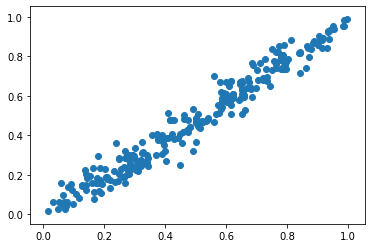

In [460]:
plt.scatter(first_match_win_probs, second_match_win_probs)

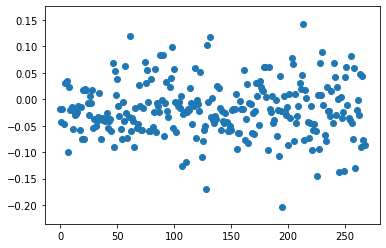

In [459]:
plt.scatter(range(len(first_match_win_probs)),
            second_match_win_probs - first_match_win_probs)